Input: csv files with coordinates from UMAP \
Ouput: Diffused plot by Datashader

In [3]:
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import datashader as ds
import datashader.transfer_functions as tf

import numpy as np

from matplotlib.patches import Patch
import numba

In [4]:
def _to_hex(arr):
    return [matplotlib.colors.to_hex(c) for c in arr]
@numba.vectorize(["uint8(uint32)", "uint8(uint32)"])
def _red(x):
    return (x & 0xFF0000) >> 16
@numba.vectorize(["uint8(uint32)", "uint8(uint32)"])
def _green(x):
    return (x & 0x00FF00) >> 8
@numba.vectorize(["uint8(uint32)", "uint8(uint32)"])
def _blue(x):
    return x & 0x0000FF
def _embed_datashader_in_an_axis(datashader_image, ax):
    img_rev = datashader_image.data[::-1]
    mpl_img = np.dstack([_blue(img_rev), _green(img_rev), _red(img_rev)])
    ax.imshow(mpl_img)
    return ax

def _get_extent(points):
    """Compute bounds on a space with appropriate padding"""
    min_x = np.nanmin(points[:, 0])
    max_x = np.nanmax(points[:, 0])
    min_y = np.nanmin(points[:, 1])
    max_y = np.nanmax(points[:, 1])

    extent = (
        np.round(min_x - 0.05 * (max_x - min_x)),
        np.round(max_x + 0.05 * (max_x - min_x)),
        np.round(min_y - 0.05 * (max_y - min_y)),
        np.round(max_y + 0.05 * (max_y - min_y)),
    )

    return extent

In [5]:
def plot_datashader(dfpaths, plotcols, plottitles, umap_columns=['umap_x','umap_y'], 
                    plot_size=1000, nrows=1, ncols=1, figsize=(20,10), pal=None, how="eq_hist"):
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    if nrows>1 or ncols>1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for dfpath, plotcol, plottitle, ax in zip(dfpaths, plotcols, plottitles, axes):
        if not isinstance(dfpath, pd.DataFrame):
            df = pd.read_csv(dfpath, low_memory=False)
        else:
            df = dfpath

        extent = _get_extent(df[['umap_x', 'umap_y']].to_numpy())

        unique_labels = df[plotcol].unique()
        if not isinstance(unique_labels, np.ndarray):
            unique_labels = unique_labels.to_numpy()
        unique_labels.sort()

        df[plotcol] = pd.Categorical(df[plotcol])
        
        if not pal:
            pal = ['darksalmon', 'lightseagreen', 'yellow', 'indigo', 'blue', 'skyblue', 
                   'orange', 'red', 'firebrick', 'lightsteelblue', 'saddlebrown', 
                   'chocolate', 'darkgreen', 'thistle', 
                   'lightcoral', 'palegoldenrod', 'sandybrown', 'floralwhite', 'darkslategray', 
                   'deepskyblue', 'darkturquoise', 'darkcyan', 'lightcyan', 'darkmagenta', 'lightgray', 
                   'mediumspringgreen', 'seashell', 'lightskyblue', 'mediumturquoise', 'darkseagreen', 'mistyrose', 
                   'rosybrown', 'mediumvioletred', 'olive', 'antiquewhite', 'dimgray', 'silver', 
                   'slategray', 'lavenderblush','dodgerblue', 
                   'lightyellow', 'darkblue', 'lightpink', 'tomato', 'linen', 
                   'mediumblue', 'darksage', 'palevioletred', 'lightsalmon', 
                   'honeydew', 'brown', 'purple', 'olivedrab', 'mediumslateblue',]

        color_key = {donor: c for (donor, c) in zip(unique_labels, pal[:unique_labels.shape[0]])}

        plotsize = plot_size
        alpha = 255
        canvas = ds.Canvas(plot_width=plotsize, plot_height=plotsize,
                           x_range=(extent[0], extent[1]), y_range=(extent[2], extent[3]))

        aggregation = canvas.points(df, 'umap_x', 'umap_y', agg=ds.count_cat(plotcol))

        legend_elements = [Patch(facecolor=color_key[k], label=k) for k in color_key.keys()]

        result = tf.shade(aggregation, color_key=color_key, how=how, alpha=alpha)
        result = tf.set_background(result, 'white')

        ax = _embed_datashader_in_an_axis(result, ax)
        ax.legend(handles=legend_elements)
#         ax.legend(handles=legend_elements, bbox_to_anchor=(0.55, -0.05))
        ax.set_title(plottitle)
        ax.axis('off')
        ax.set_yticklabels([])
        ax.set_xticklabels([])

    plt.tight_layout()
    plt.show()

In [75]:
pal = ['green', 'lightseagreen', 'mediumslateblue', 
       'indigo', 'blue', 'skyblue', 
       'salmon', 'red', 'firebrick', 
       'lightsteelblue', 'saddlebrown', 'chocolate', 
       'darkgreen', 'thistle', 
       'lightcoral', 'palegoldenrod', 'sandybrown', 'floralwhite', 'darkslategray', 
       'deepskyblue', 'darkturquoise', 'darkcyan', 'lightcyan', 'darkmagenta', 'lightgray', 
       'mediumspringgreen', 'seashell', 'lightskyblue', 'mediumturquoise', 'darkseagreen', 'mistyrose', 
       'rosybrown', 'mediumvioletred', 'olive', 'antiquewhite', 'dimgray', 'silver', 
       'slategray', 'lavenderblush','dodgerblue', 
       'lightyellow', 'darkblue', 'lightpink', 'tomato', 'linen', 
       'mediumblue', 'darksage', 'palevioletred', 'lightsalmon', 
       'honeydew', 'brown', 'purple', 'olivedrab', 'mediumslateblue',]

In [1]:
csv_paths = list('/path/to/umap_coords/*.csv')

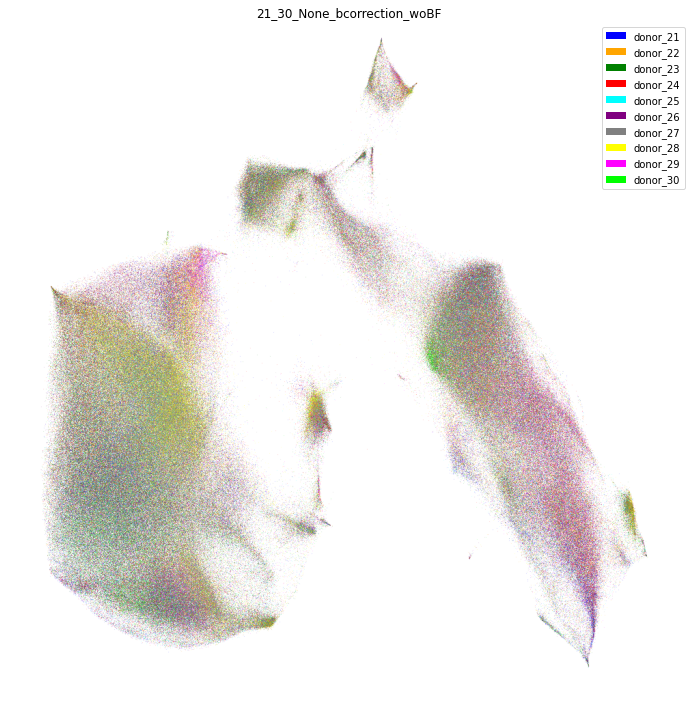

In [14]:
plot_titles = [cp.parent.stem for cp in csv_paths]
plot_datashader(csv_paths, plotcols=['donor'] * len(csv_paths), plottitles=plot_titles, nrows=1, ncols=len(csv_paths), pal=pal)